# Detección de anomalías: Encontrar que temperaturas son una anomalía usando Isolation Forest.

**Vida Artificial** 
- Karolina Condori Flores, 161983 
- Denis Vasquez Canaza, 16299

Paso 01: Importar la librerías pandas, numpy, seaborn, matplotlib y sklearn.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest

plt.rcParams['figure.figsize'] = 40, 10

Paso 02: Leer el dataset de temperatura externamente y convertir de Fahrenheit a Celsius.

In [ ]:
Dataset = pd.read_csv("/content/drive/MyDrive/Inteligencia Computacional/Aprendizaje No Supervisado/ambient_temperature_system_failure.csv", sep = ',', low_memory = False)
Dataset = Dataset.rename(columns = {"timestamp":"Date", "value":"Temperature"})
Dataset['Temperature'] = pd.to_numeric(Dataset['Temperature'])
Dataset['Date'] = pd.to_datetime(Dataset['Date'])

# Fahrenheit a Celsius 
Dataset['Temperature'] = (Dataset['Temperature'] - 32) * 5/9


Paso 03: Prepocesamiento de los datos

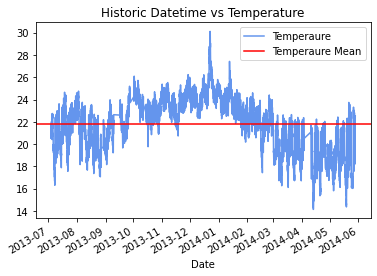

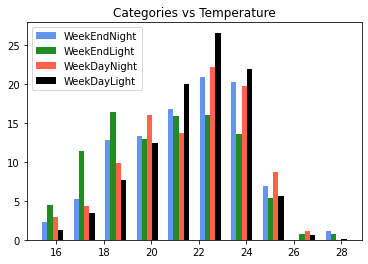

In [ ]:
#Prepocesamiento

#Hallar la distancia entre centros de los clústeres mediante la funcion GetDistanceByPoint 
class Utils:

    def GetDistanceByPoint(ClusterDataset, ClusterModel):
        ClusterDistance = pd.Series()
        for Cluster in range(0, len(ClusterDataset)):
            FirstPoint = np.array(ClusterDataset.loc[Cluster])
            SecondPoint = ClusterModel.cluster_centers_[ClusterModel.labels_[Cluster] - 1]
            ClusterDistance.set_value(Cluster, np.linalg.norm(FirstPoint - SecondPoint))
        return ClusterDistance
#Encapsular una serie de columnas en las cuales aparecen clases de fechas.
class DateFeatures:   
    
    Dataset['Hours'] = Dataset['Date'].dt.hour
    Dataset['DayLight'] = ((Dataset['Hours'] > 7 & (Dataset['Hours'] < 22))).astype(int)
    Dataset['DayOfTheWeek'] = Dataset['Date'].dt.dayofweek
    Dataset['WeekDay'] = (Dataset['DayOfTheWeek'] < 5).astype(int)
    Dataset['TimeEpoch'] = (Dataset['Date'].astype(np.int64)/100000000000).astype(np.int64)

#Mostrar ploteos que nos pueden ayudar a ver mejor la distribución de los datos.
class PreprocessingVisualization(DateFeatures):
    
    def HistoricDatePlot():
        Dataset.plot(x = 'Date', y = 'Temperature', color = 'cornflowerblue', label = 'Temperaure')
        plt.axhline(np.mean(Dataset['Temperature']), color = 'red', label = 'Temperaure Mean')
        
    def CategoriesBarPlot():
        
        Dataset['Categories'] = Dataset['WeekDay']*2 + Dataset['DayLight']

        WeekEndNight = Dataset.loc[Dataset['Categories'] == 0, 'Temperature']
        WeekEndLight = Dataset.loc[Dataset['Categories'] == 1, 'Temperature']
        WeekDayNight = Dataset.loc[Dataset['Categories'] == 2, 'Temperature']
        WeekDayLight = Dataset.loc[Dataset['Categories'] == 3, 'Temperature']

        Fig, ax = plt.subplots()
        
        WeekEndNightHeights, WeekEndNightBins = np.histogram(WeekEndNight)
        WeekEndLightHeights, WeekEndLightBins = np.histogram(WeekEndLight, bins = WeekEndNightBins)
        WeekDayNightHeights, WeekDayNightBins = np.histogram(WeekDayNight, bins = WeekEndNightBins)
        WeekDayLightHeights, WeekDayLightBins = np.histogram(WeekDayLight, bins = WeekEndNightBins)
        
        Width = (WeekEndNightBins[1] - WeekEndNightBins[0])/6
        
        ax.bar(WeekEndNightBins[:-1], (WeekEndNightHeights*100/WeekEndNight.count()), width = Width, 
               facecolor = 'cornflowerblue', label = 'WeekEndNight')
        ax.bar(WeekEndLightBins[:-1] + Width, (WeekEndLightHeights*100/WeekEndLight.count()), width = Width, 
               facecolor = 'forestgreen', label = 'WeekEndLight')
        ax.bar(WeekDayNightBins[:-1] + Width*2, (WeekDayNightHeights*100/WeekDayNight.count()), width = Width, 
               facecolor = 'tomato', label = 'WeekDayNight')
        ax.bar(WeekDayLightBins[:-1] + Width*3, (WeekDayLightHeights*100/WeekDayLight.count()), width = Width, 
               facecolor = 'black', label = 'WeekDayLight')

PreprocessingVisualization.HistoricDatePlot()
plt.title('Historic Datetime vs Temperature')
plt.legend()
plt.show()

PreprocessingVisualization.CategoriesBarPlot()
plt.title('Categories vs Temperature')
plt.legend()
plt.show()

# Aplicando el modelo Isolation Forest

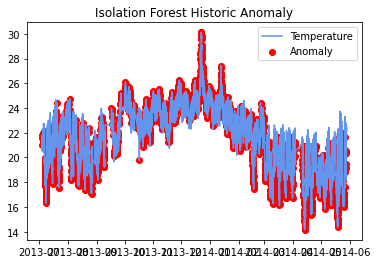

In [ ]:
class IsolationForestModel():

    #Asginando la temperatura y las clases de fechas a DataIsolationForest.
    DataIsolationForest = Dataset[['Temperature', 'Hours', 'DayLight', 'DayOfTheWeek', 'WeekDay']]
    
    #Estandarizar características eliminando la media y escalando a la varianza de la unidad
    StandardScaler = preprocessing.StandardScaler()
    DataIsolationForestScaled = StandardScaler.fit_transform(DataIsolationForest)
    DataIsolationForest = pd.DataFrame(DataIsolationForestScaled)
    
    #Usar el algoritmo IsolationForest y entrenar el dataset DataIsolationForest.
    Model = IsolationForest()
    Model.fit(DataIsolationForest)
    
    DataIsolationForest['AnomalyIsolationForest'] = pd.Series(Model.predict(DataIsolationForest))
    DataIsolationForest['AnomalyIsolationForest'] = DataIsolationForest['AnomalyIsolationForest'].map({1: 0, -1: 1})
    
    AnomalyCondition = Dataset.loc[DataIsolationForest['AnomalyIsolationForest'] == 1, ['Date', 'Temperature']] 
    #Plotear el modelo Isolation Forest
    def IsolationForestDatePlot():
        FigIsolationForest, ax = plt.subplots() 
        ax.plot(Dataset['Date'], Dataset['Temperature'], color = 'cornflowerblue', label = 'Temperature')
        ax.scatter(IsolationForestModel.AnomalyCondition['Date'], IsolationForestModel.AnomalyCondition['Temperature'], 
                   color = 'red', label = 'Anomaly')

IsolationForestModel.IsolationForestDatePlot()
plt.title('Isolation Forest Historic Anomaly')
plt.legend()
plt.show()